In [1]:
from typing import *
from pathlib import Path
from tqdm import tqdm


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
np.random.seed(42)


ROOT_DIR = Path(os.getcwd()).parent.parent

In [2]:
df: pd.DataFrame = pd.read_parquet(os.path.join(ROOT_DIR, "data/datasets/train_17_08.parquet"))

df = df.reset_index(drop=True)
# Create pump hash and convert pump time to datetime
df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["pump_time"] = pd.to_datetime(df["pump_time"])


df["is_pumped"].value_counts()

is_pumped
False    59917
True       470
Name: count, dtype: int64

In [3]:
drop_groups: List[str] = [
    "linear_liquidity_slope",
    "has_slippage_slope",
    "has_slippage_intercept",
]

cols: List[str] = [col for col in df.columns if all([group not in col for group in drop_groups])]
df: pd.DataFrame = df[cols].copy()

df.head(3)

,overall_return_1h,volume_quote_abs_zscore_1h_30d,num_trades_long_share_1h,volume_quote_long_share_1h,overall_return_6h,volume_quote_abs_zscore_6h_30d,num_trades_long_share_6h,volume_quote_long_share_6h,log_return_std_6h_30d,log_return_zscore_6h_30d,...,quote_abs_powerlaw_alpha_48h,quote_abs_powerlaw_alpha_60h,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
0,1.021859,2.280969,0.516556,0.835675,1.027331,-0.090107,0.590278,0.726476,0.923933,0.344018,...,1.330812,1.331458,0,binance,ACMBTC,2021-06-05 18:00:13,RCNBTC,False,1305,ACMBTC_2021-06-05 18:00:13
1,0.987035,-0.636960,0.362069,0.239926,0.959109,-0.443674,0.388672,0.332859,0.438048,-0.369176,...,1.243441,1.248743,0,binance,ACMBTC,2021-06-05 18:00:13,BELBTC,False,263,ACMBTC_2021-06-05 18:00:13
2,1.004890,-0.818392,0.434783,0.133751,0.985353,-0.664154,0.530822,0.419453,0.512068,-0.136323,...,1.141185,1.141809,0,binance,ACMBTC,2021-06-05 18:00:13,LOOMBTC,False,1130,ACMBTC_2021-06-05 18:00:13


Replace infs to nans

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)

df.isna().sum().sort_values(ascending=False).head(10)

quote_slippage_imbalance_ratio_1h     5580
quote_slippage_imbalance_ratio_3h     1729
quote_slippage_imbalance_ratio_6h      809
quote_slippage_imbalance_ratio_12h     383
log_return_std_6h_30d                  212
log_return_zscore_6h_30d               199
quote_abs_powerlaw_alpha_1h            185
quote_slippage_imbalance_ratio_24h     156
num_trades_long_share_1h                79
volume_quote_long_share_1h              79
dtype: int64

In [5]:
reg_cols: List[str] = df.columns[:-7].tolist()
num_cols: List[str] = df.columns[:-8].tolist()

len(reg_cols)

69

<h4>Check how many missing values we have</h4>

In [6]:
df.isna().sum().sort_values()

overall_return_1h                        0
is_pumped                                0
ticker                                   0
pump_time                                0
pumped_ticker                            0
                                      ... 
log_return_std_6h_30d                  212
quote_slippage_imbalance_ratio_12h     383
quote_slippage_imbalance_ratio_6h      809
quote_slippage_imbalance_ratio_3h     1729
quote_slippage_imbalance_ratio_1h     5580
Length: 76, dtype: int64

<h4>Remove all crosssections without pump observations and pumps with nans </h4>

In [7]:
df_pumps: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df.groupby("pump_hash")):
    # check if each crosssection contains only 1 pumped ticker and pumped ticker has no missing values across all columns
    if (df_pump["is_pumped"].sum() == 1) and all(df_pump[df_pump["is_pumped"]].notna().all()):

        for col in reg_cols: # fill nans with median
            col_median: float = df_pump[col].median()
            df_pump[col] = df_pump[col].fillna(col_median)

        df_pumps: pd.DataFrame = pd.concat([df_pumps, df_pump])


df_pumps["is_pumped"].value_counts()

100%|██████████| 470/470 [00:05<00:00, 87.82it/s]


is_pumped
False    57094
True       448
Name: count, dtype: int64

<h4>Describe cols</h4>

In [9]:
df_pumps[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
overall_return_1h,57542.0,1.000241,0.023245,0.564881,0.992674,1.000000,1.006851,1.518794
volume_quote_abs_zscore_1h_30d,57542.0,0.513645,6.897607,-2.765859,-0.488701,-0.238925,0.329047,877.536349
num_trades_long_share_1h,57542.0,0.515653,0.160138,0.000000,0.423077,0.515695,0.610687,1.000000
volume_quote_long_share_1h,57542.0,0.472210,0.223507,0.000000,0.317791,0.469593,0.620008,1.000000
overall_return_6h,57542.0,1.000690,0.043037,-0.058016,0.982282,0.998851,1.015070,2.245771
...,...,...,...,...,...,...,...,...
quote_abs_powerlaw_alpha_6h,57542.0,1.229468,0.095746,1.085779,1.172956,1.216129,1.265723,5.388625
quote_abs_powerlaw_alpha_12h,57542.0,1.213511,0.082841,1.085860,1.161733,1.201904,1.245258,4.958618
quote_abs_powerlaw_alpha_24h,57542.0,1.199016,0.072436,1.084541,1.152922,1.187835,1.228639,4.713602
quote_abs_powerlaw_alpha_48h,57542.0,1.186481,0.064711,1.083779,1.144947,1.176047,1.214469,4.552822


<h4>Remove outliers</h4>

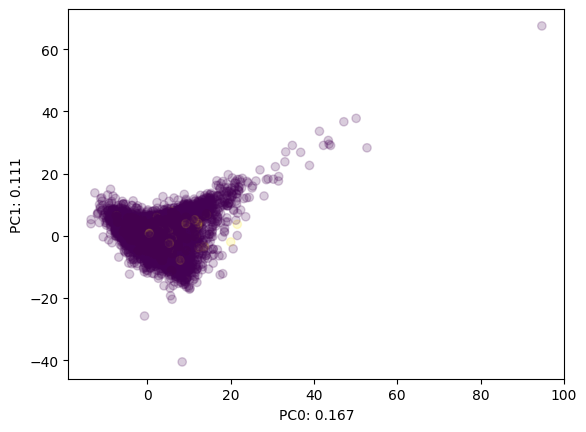

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(df_pumps[num_cols])

pca = PCA(n_components=X.shape[1])
PCA_proj = pca.fit_transform(X)

plt.scatter(
    PCA_proj[:, 0], PCA_proj[:, 1], c=df_pumps["is_pumped"], alpha=.2
)

plt.xlabel(f"PC0: {pca.explained_variance_ratio_[0]:.3f}")
plt.ylabel(f"PC1: {pca.explained_variance_ratio_[1]:.3f}")


plt.show()

In [15]:
outlier_mask = df_pumps[num_cols] <= df_pumps[num_cols].quantile(.999)
df_clean = df_pumps[outlier_mask.all(axis=1)].copy()

df_clean["is_pumped"].value_counts()

is_pumped
False    55700
True       440
Name: count, dtype: int64

<h4>Remove crosssections without pumps</h4>

In [16]:
df_filtered: pd.DataFrame = pd.DataFrame()

for pump_hash, df_pump in tqdm(df_clean.groupby("pump_hash")):
    # check if each crosssection contains only 1 pumped ticker and pumped ticker has no missing values across all columns
    if (df_pump["is_pumped"].sum() == 1) and all(df_pump[df_pump["is_pumped"]].notna().all()):
        df_filtered: pd.DataFrame = pd.concat([df_filtered, df_pump])

df_filtered["is_pumped"].value_counts()

100%|██████████| 448/448 [00:02<00:00, 217.60it/s]


is_pumped
False    54624
True       440
Name: count, dtype: int64

<h4>Distribution of regressor variables</h4>

In [17]:
col_groups: List[str] = [
    "overall_return",
    "volume_quote_abs_zscore",
    "volume_quote_long_share",
    "log_return_std",
    "log_return_zscore",
    "quote_slippage_abs_share",
    "quote_imbalance_ratio",
    "quote_slippage_imbalance_ratio",
    "quote_abs_powerlaw_alpha",
    "num_prev_pumps",
]

In [18]:
col_map: Dict[str, List[str]] = {}

for group in col_groups:
    col_map[group] = [col for col in df_pumps.columns if group in col]

In [19]:
def plot_hist_cols(df: pd.DataFrame, col_map: Dict[str, List[str]]):
    for group, cols in tqdm(col_map.items()):
        fig, axs = plt.subplots(
            nrows=int(np.ceil(len(cols) / 4)), ncols=4, figsize=(20, 6)
        )
        axs = axs.flatten()

        for ax, col in tqdm(zip(axs, cols), total=len(cols), leave=False):
            sns.histplot(
                data=df, x=col, legend=False, stat="probability", ax=ax
            )
        fig.tight_layout()
        fig.show()

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


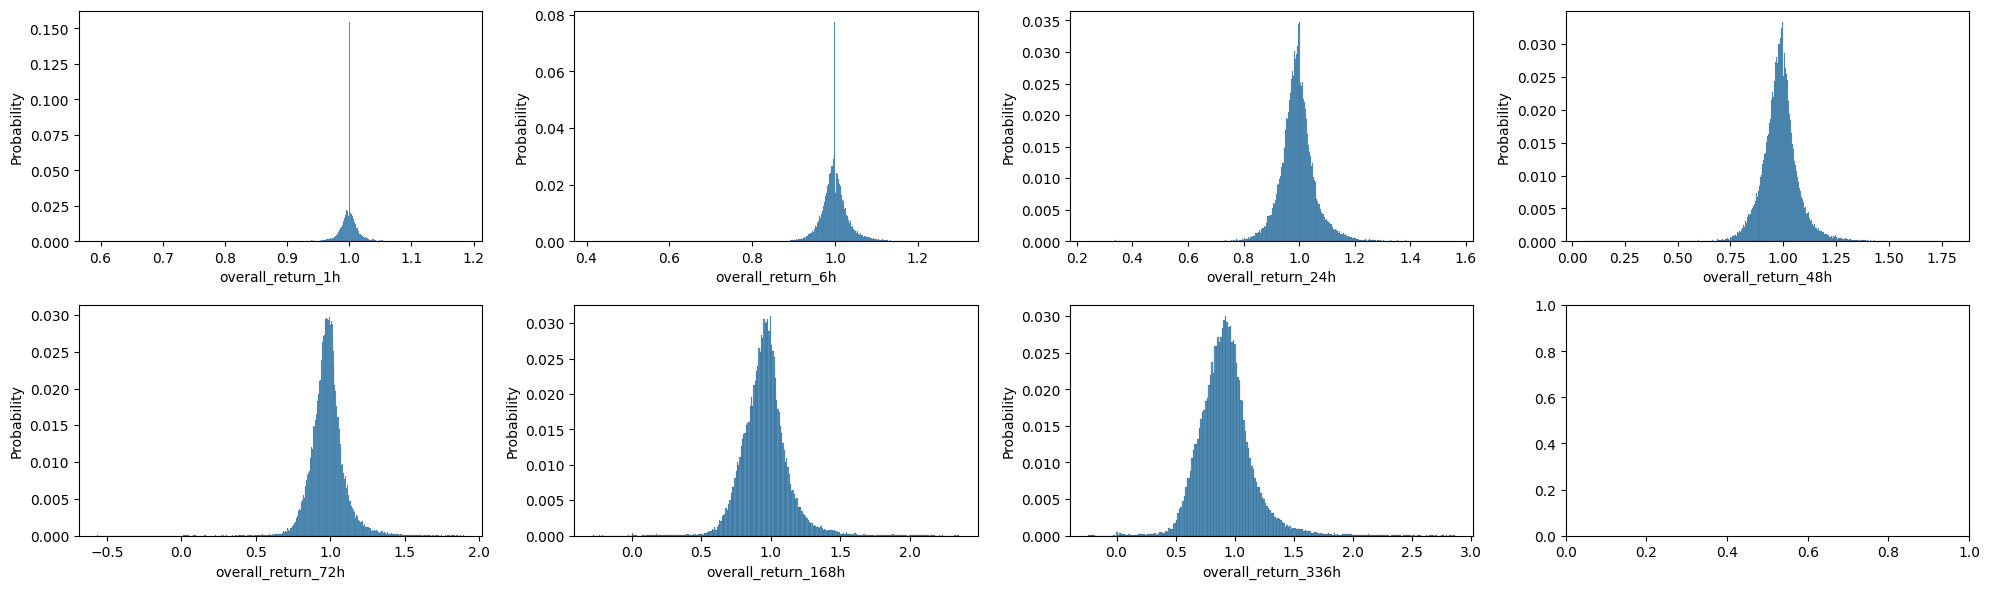

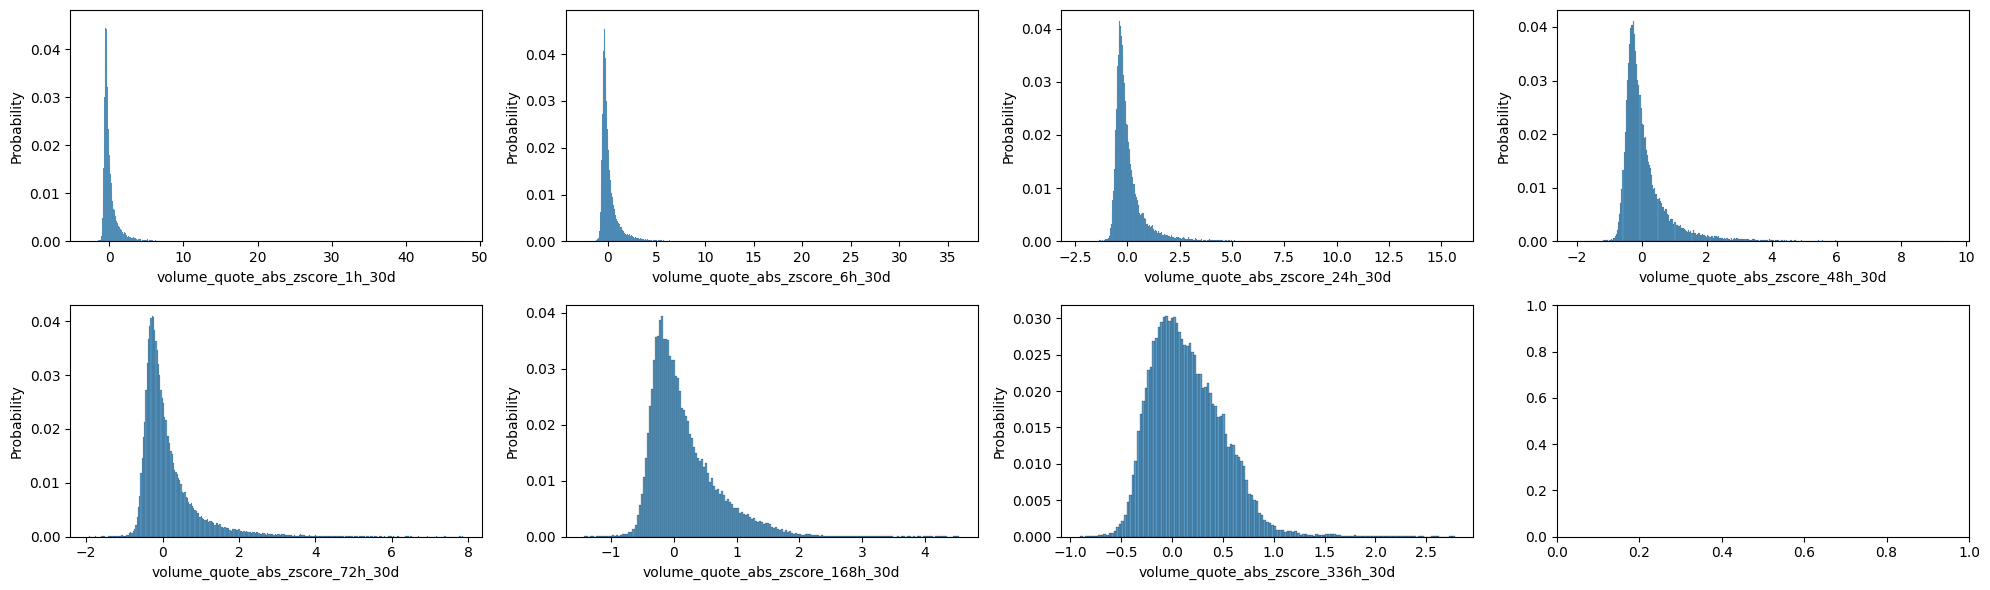

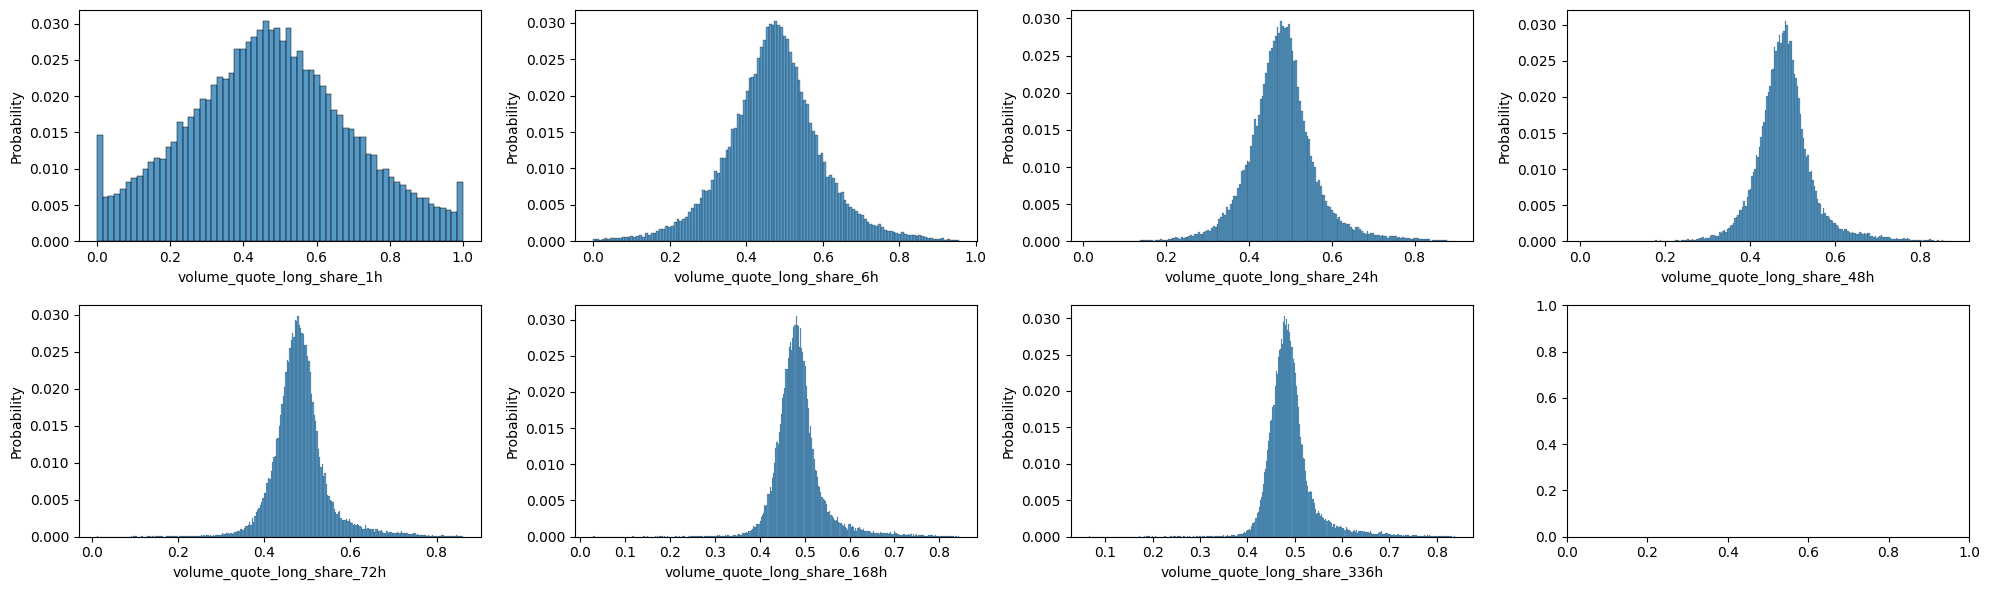

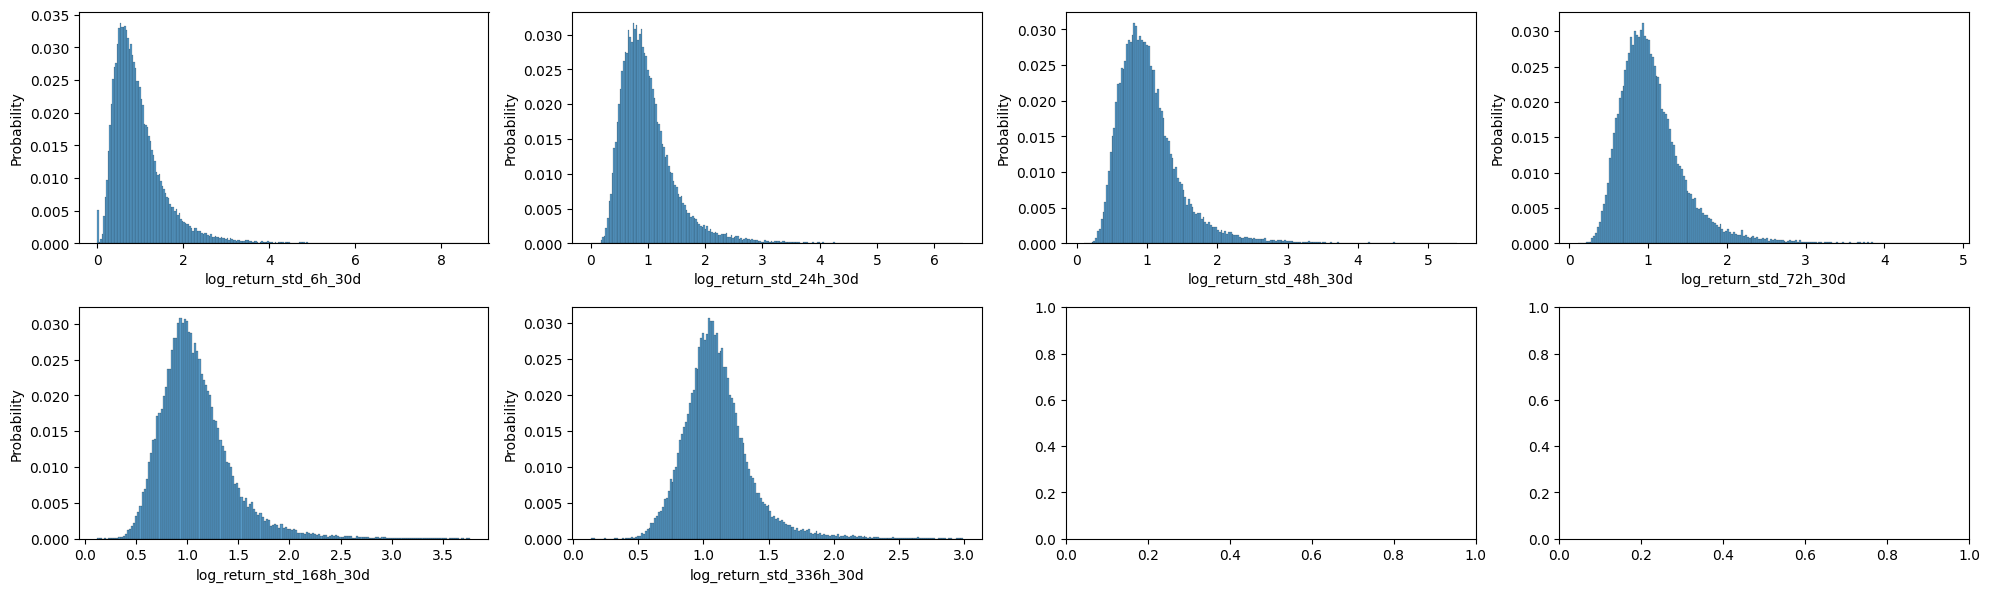

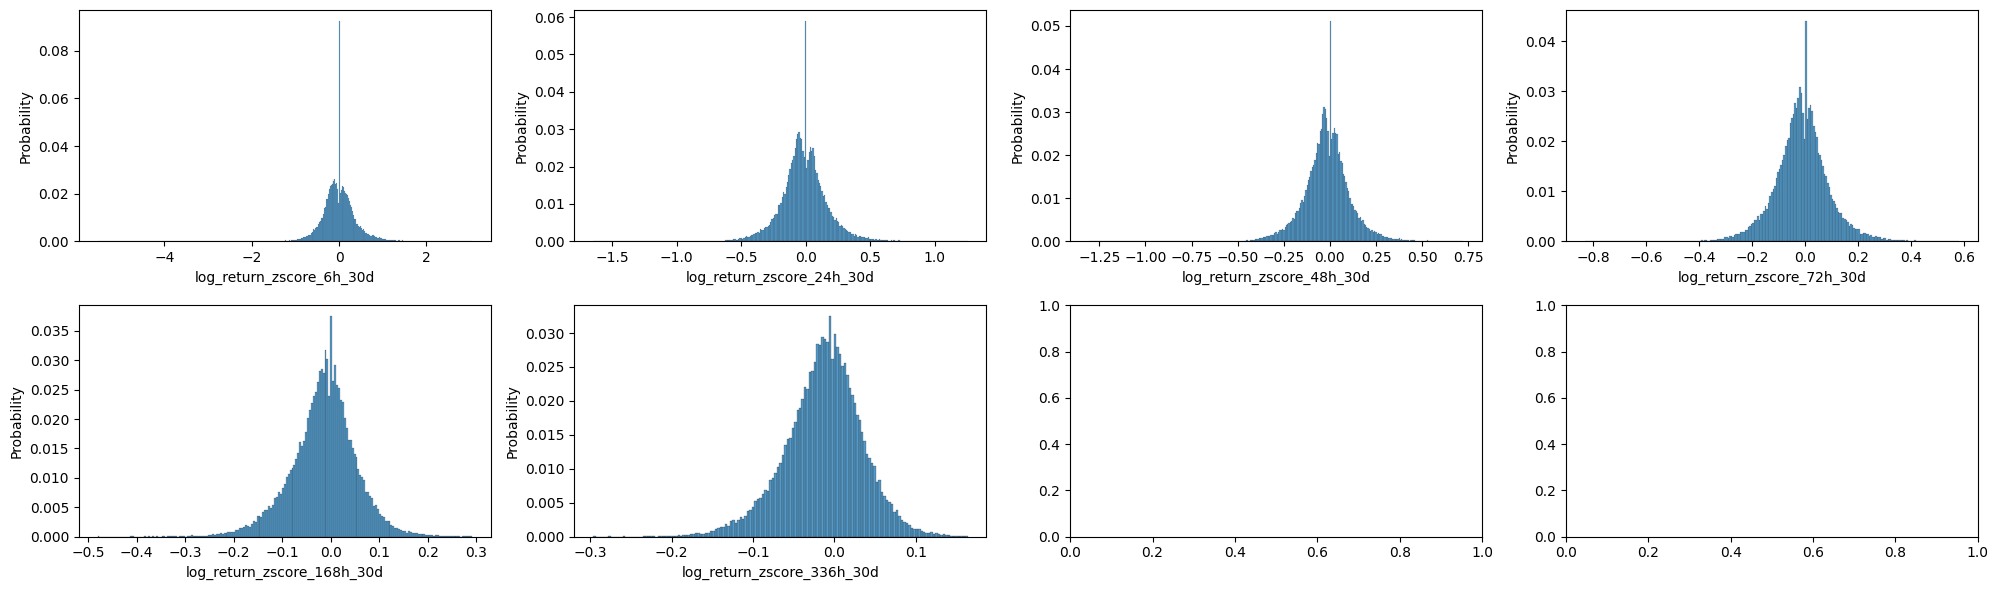

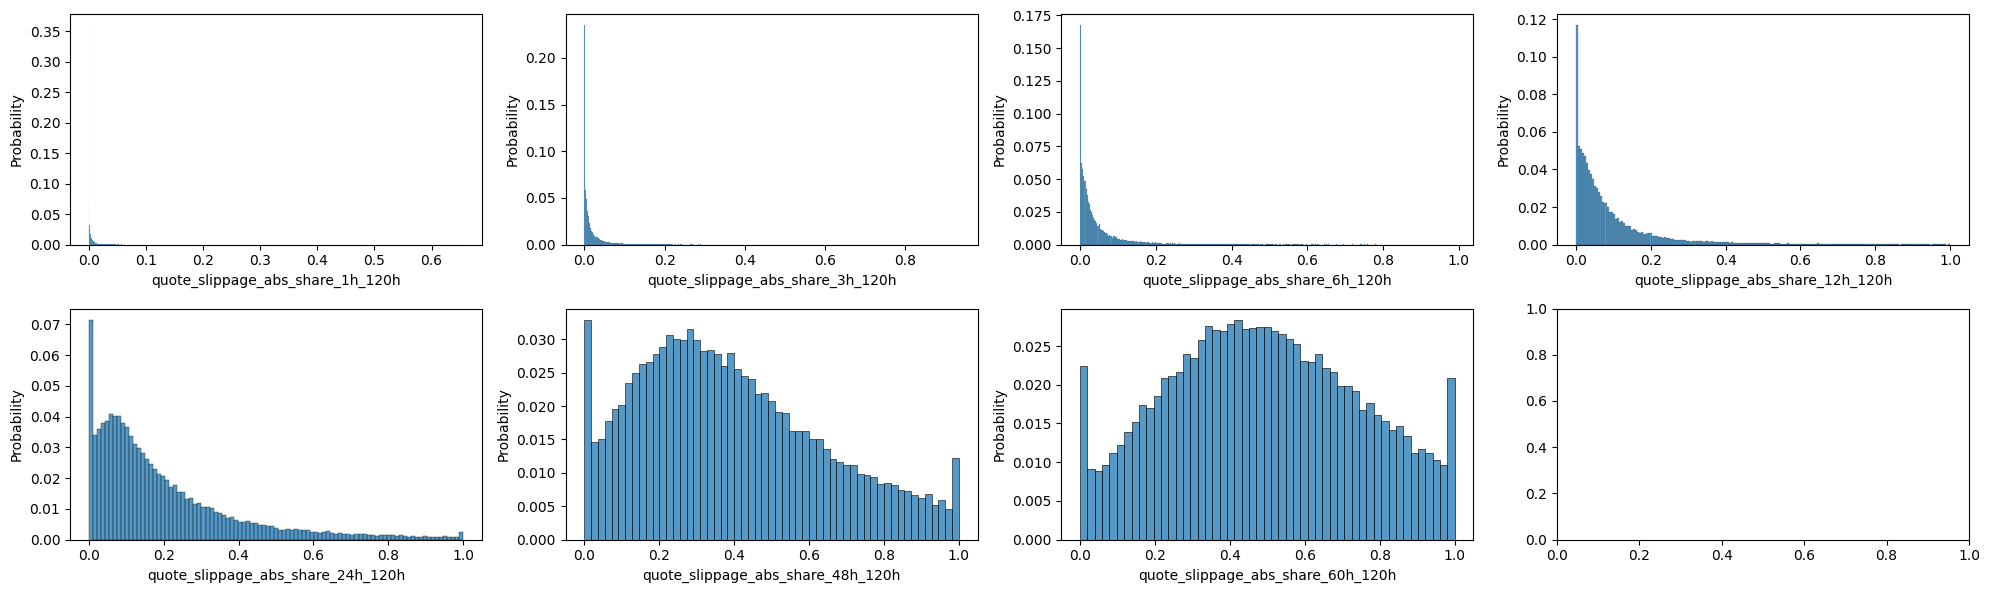

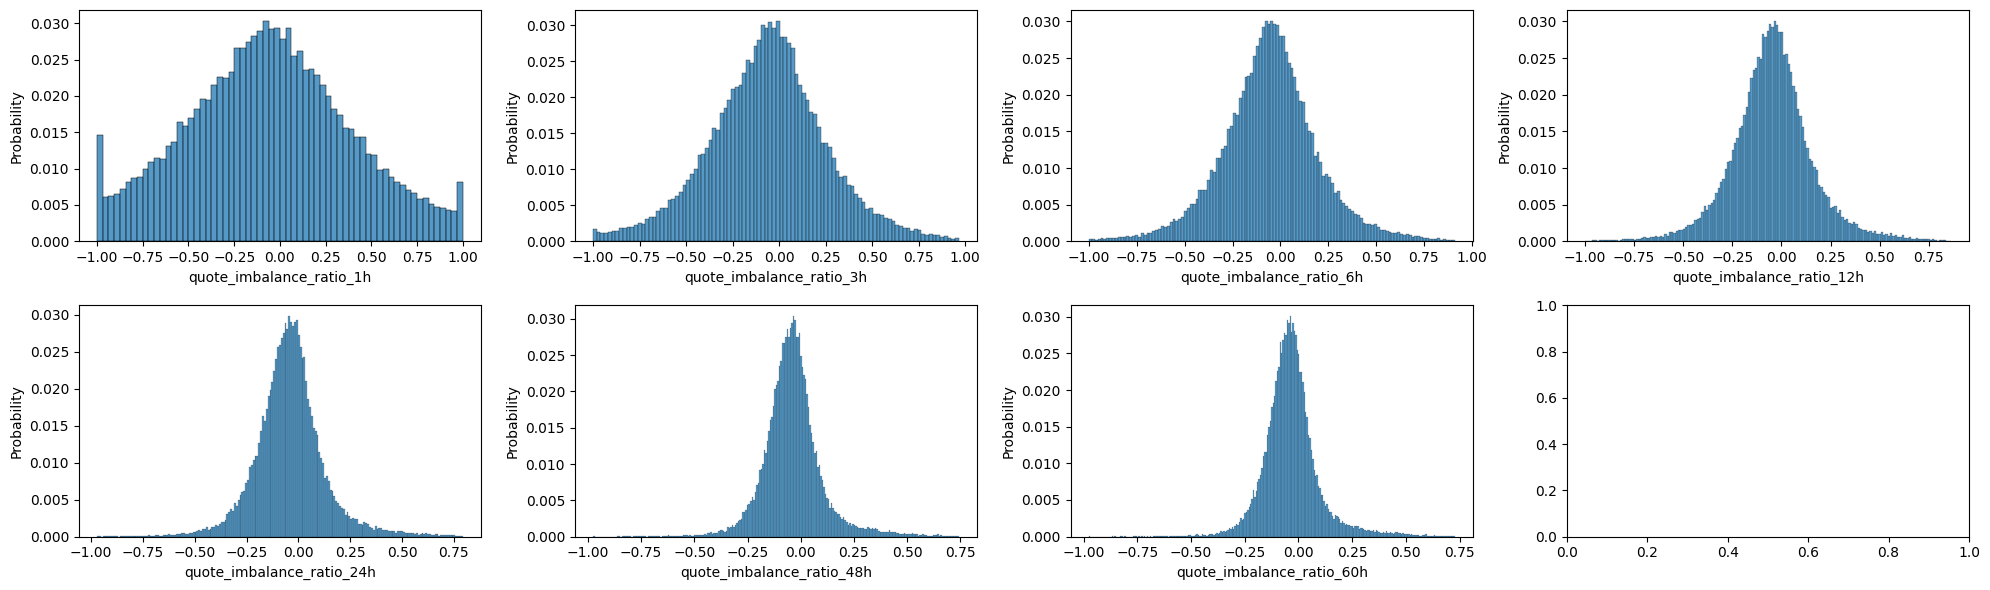

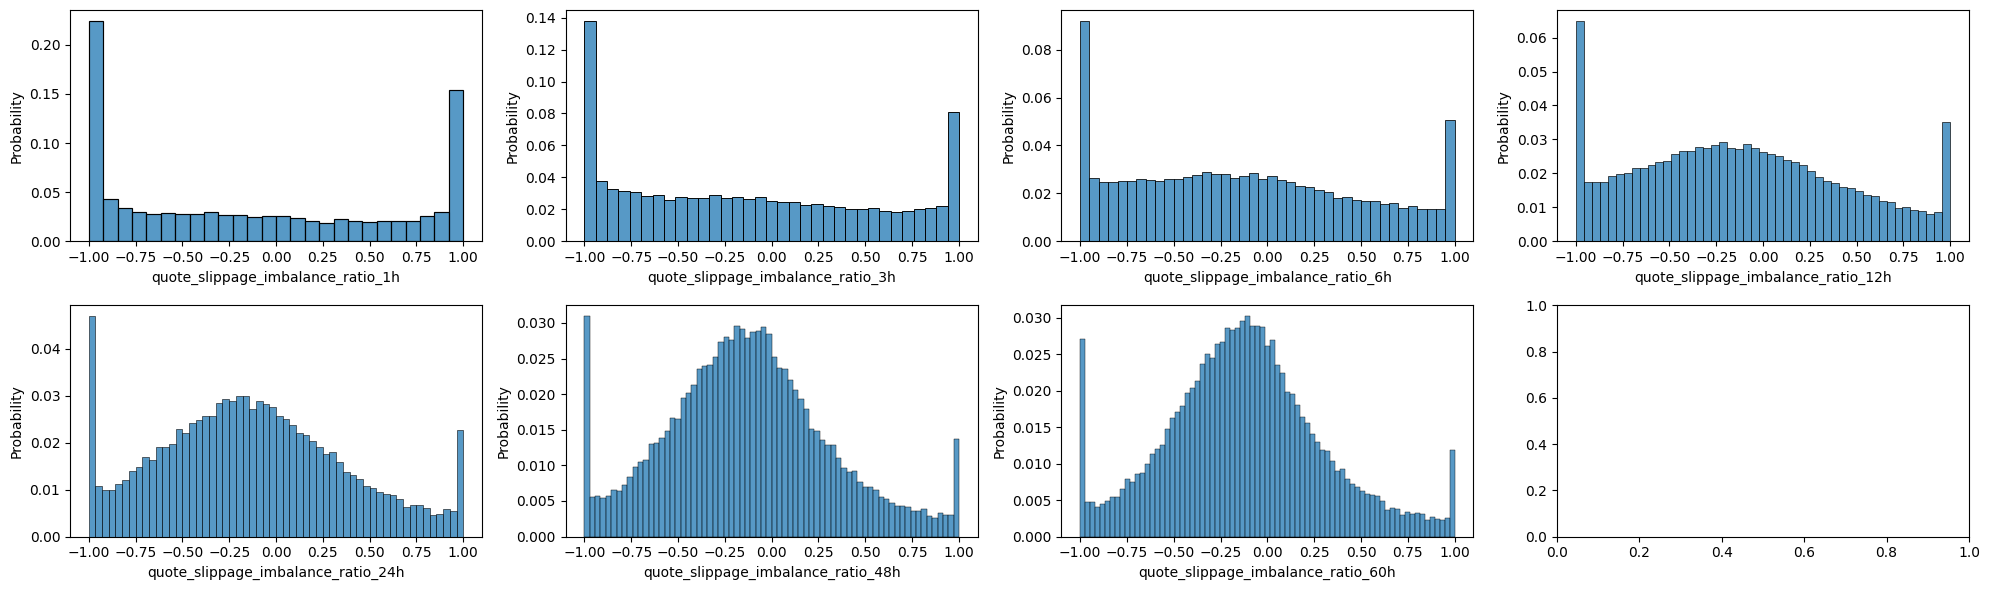

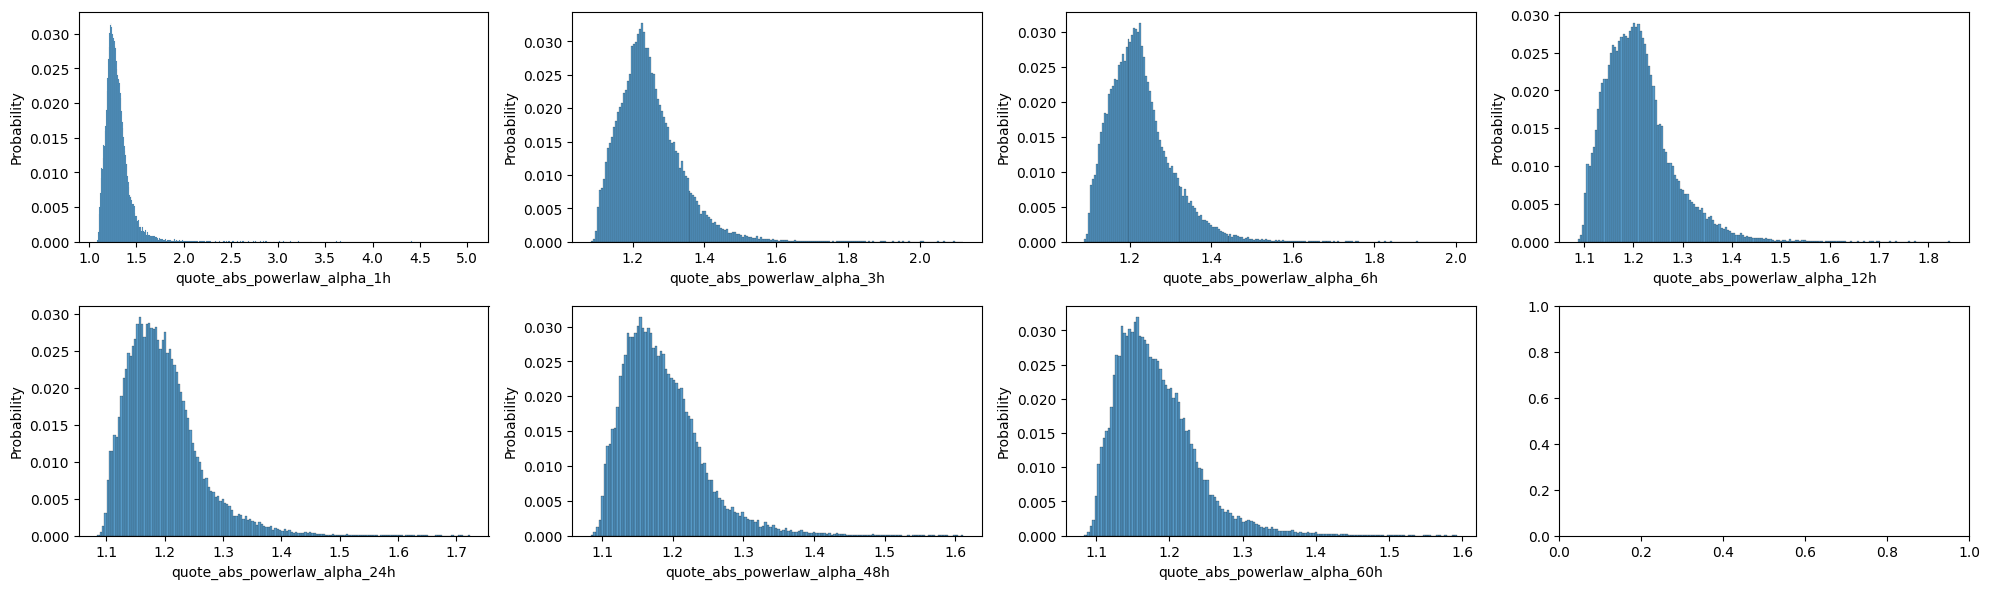

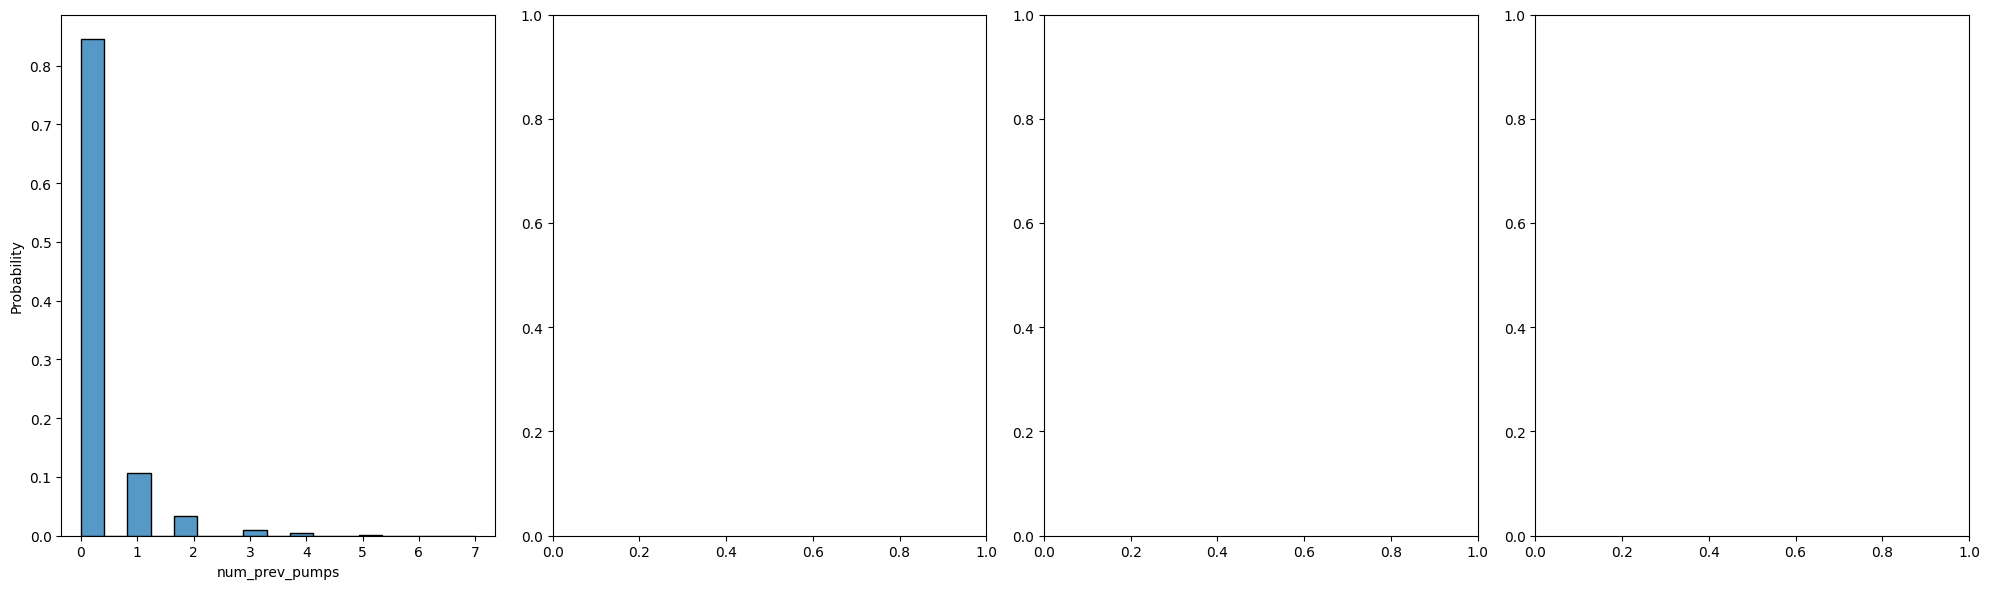

In [20]:
plot_hist_cols(df=df_filtered, col_map=col_map)

<h4>Preprocess some columns</h4>

In [21]:
groups_to_log: List[str] = [
    "volume_quote_abs_zscore",
]

In [22]:
for group in groups_to_log:
    for col in col_map[group]:
        df_filtered[col] += np.abs(df_filtered[col].min()) + 0.01 # transform features to positive to take logs
        df_filtered[col] = np.log(df_filtered[col])

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


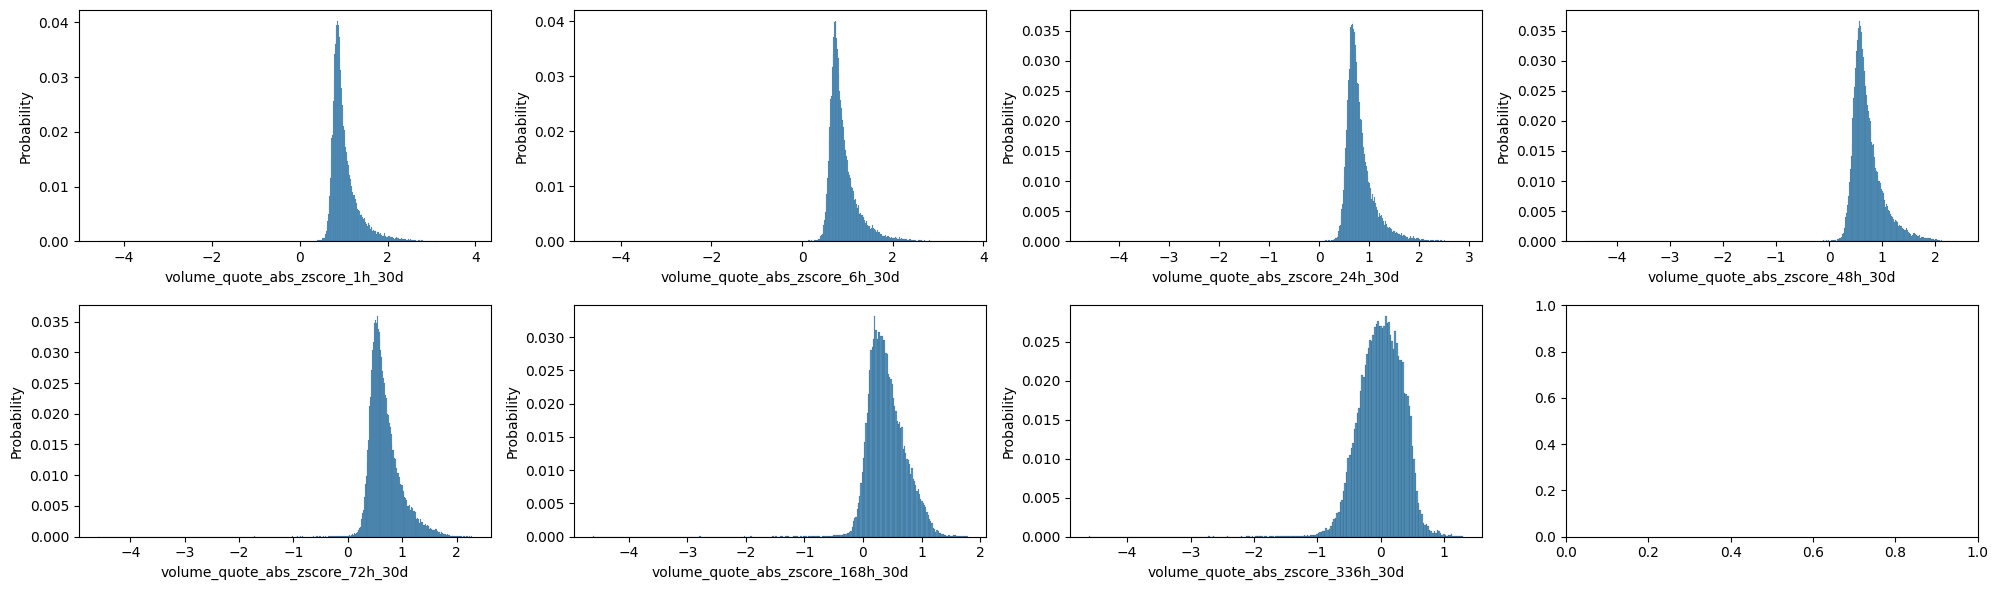

In [23]:
plot_hist_cols(
    df=df_filtered, col_map={key: val for key, val in col_map.items() if key in groups_to_log}
)

<h4>Apply cross-sectional normalization</h4>

In [24]:
groups_to_scale: List[str] = [
    "overall_return",
    "volume_quote_abs_zscore",
    "log_return_std",
    "log_return_zscore",
    "quote_abs_powerlaw_alpha",
]


cols_to_scale: List[str] = []

for group in groups_to_scale:
    cols_to_scale.extend(col_map[group])

In [25]:
df_scaled: pd.DataFrame = pd.DataFrame()

# group by pump crosssections and standardize by within moments
for i, (pump_hash, df_pump) in tqdm(enumerate(df_filtered.groupby("pump_hash"))):
    for col in cols_to_scale:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_scaled: pd.DataFrame = pd.concat([df_scaled, df_pump])

df_scaled["is_pumped"].value_counts()

440it [00:03, 110.57it/s]


is_pumped
False    54624
True       440
Name: count, dtype: int64

<h4>Plot distributions with and without Crossectional Standardisation</h4>

100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


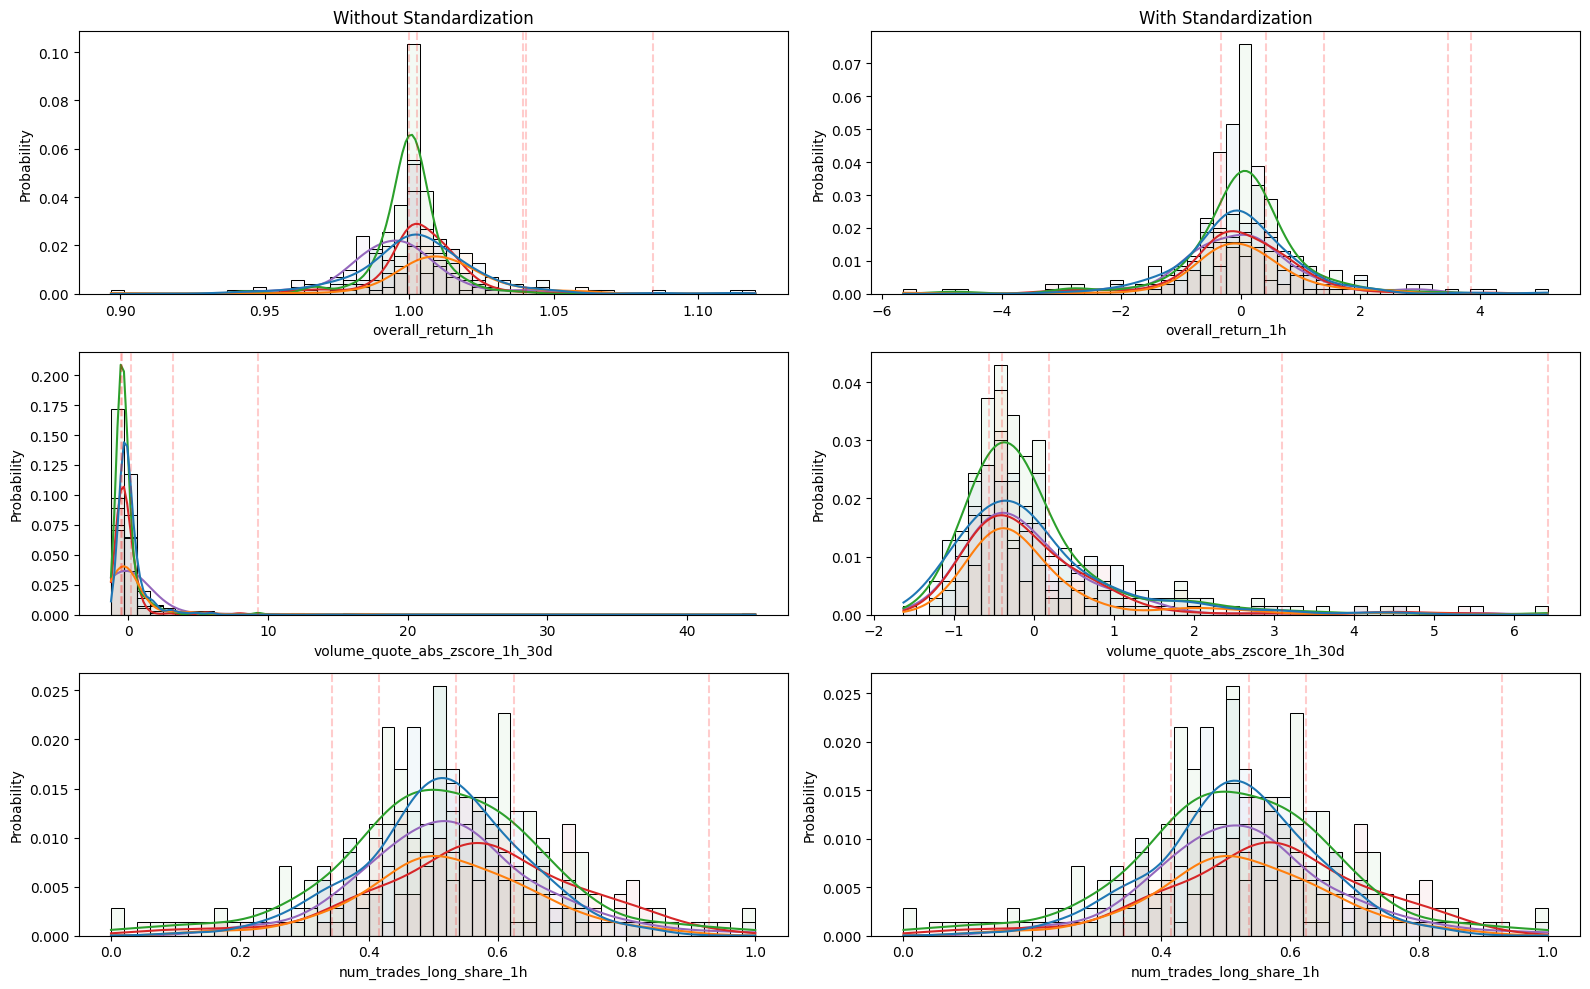

In [26]:
pumps_plot: np.array = np.random.choice(df_pumps["pump_hash"].unique(), 5, replace=False)  # choose 5 random pumps to plot

df_plot: pd.DataFrame = df_pumps[df_pumps["pump_hash"].isin(pumps_plot)].copy()
df_plot_scaled: pd.DataFrame = df_scaled[df_scaled["pump_hash"].isin(pumps_plot)].copy()

cols_to_plot = num_cols[:3]

fig, axs = plt.subplots(3, 2, figsize=(16, 10))

for col, (ax1, ax2) in tqdm(zip(cols_to_plot, axs), total=3):

    # Plot not scaled and scaled hists
    sns.histplot(
        data=df_plot, x=col, hue="pump_hash", ax=ax1, legend=False, alpha=0.05, bins=50, kde=True, stat="probability"
    )
    sns.histplot(
        data=df_plot_scaled, x=col, hue="pump_hash", ax=ax2, legend=False, alpha=0.05, bins=50, kde=True, stat="probability"
    )

    for pump_hash in pumps_plot:
        pumped_ticker: pd.Series = (df_plot["pump_hash"] == pump_hash) & (df_plot["is_pumped"])
        pumped_ticker_scaled: pd.Series = (df_plot_scaled["pump_hash"] == pump_hash) & (df_plot_scaled["is_pumped"])

        ax1.axvline(x=df_plot[pumped_ticker][col].iloc[-1], color="red", linestyle="--", alpha=0.2)
        ax2.axvline(x=df_plot_scaled[pumped_ticker_scaled][col].iloc[-1], color="red", linestyle="--", alpha=0.2)

for ax, col in zip(axs[0], ["Without Standardization", "With Standardization"]):
    ax.set_title(col)


plt.tight_layout()
plt.show()

<h4>Remove failed pumps. Where pumped ticker is not among the highest in terms of returns</h4>

In [27]:
from datetime import datetime, timedelta
from dataclasses import dataclass


@dataclass
class Ticker:
    ticker: str
    time: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Ticker: {self.ticker} - {str(self.time)}"


# load trade data for a given ticker
def load_data(
    ticker: Ticker,
    lookback_delta: timedelta,
    forward_delta: timedelta = -timedelta(hours=1),  # by default it is set to -1 hours
) -> pd.DataFrame:

    end: pd.Timestamp = ticker.time + forward_delta
    start: pd.Timestamp = ticker.time - lookback_delta

    date_range: List[pd.Timestamp] = pd.date_range(start=start, end=end, freq="D", inclusive="both").tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{ticker.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/{ticker.ticker}", file_name)
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")
    df = df[(df["time"] >= start) & (df["time"] <= end)].reset_index(drop=True)

    df["quote_abs"] = df["price"] * df["qty"]  # calculate quote spent

    return df

In [28]:
def compute_return(ticker: Ticker) -> float:
    """Calculates return of the ticker around some pump.time"""
    try:
        df_asset: pd.DataFrame = load_data(
            ticker=ticker, lookback_delta=timedelta(hours=1), forward_delta=timedelta(hours=1)
        )
    except FileNotFoundError:
        return 0

    df_asset: pd.DataFrame = df_asset[
        (df_asset["time"] >= ticker.time - timedelta(minutes=1)) & (df_asset["time"] <= ticker.time + timedelta(minutes=5))
    ].copy()

    if df_asset.empty:
        return 0

    start_price, max_price = df_asset["price"].iloc[0], df_asset["price"].max()
    asset_return: float = (max_price - start_price) / start_price

    return asset_return

In [29]:
df_returns: pd.DataFrame = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in tqdm(df_scaled.groupby(["pumped_ticker", "pump_time"])):
    tickers_crosssection: List[str] = df_pump["ticker"].tolist()
    asset_returns: List[float] = []

    for ticker in tickers_crosssection:
        ticker_obj: Ticker = Ticker(ticker=ticker, time=pump_time)
        asset_returns.append(compute_return(ticker=ticker_obj))

    df_pump["asset_return"] = asset_returns
    df_returns = pd.concat([df_returns, df_pump])

100%|██████████| 440/440 [10:15<00:00,  1.40s/it]


In [31]:
# rank assets by their max returns within each crosssection
df_returns["asset_return_rank"] = df_returns.groupby("pump_hash")["asset_return"].rank(ascending=False)

In [37]:
df_filtered_returns: pd.DataFrame = pd.DataFrame()

i = 0

for pump_id, df_pump in tqdm(df_returns.groupby("pump_hash")):
    if df_pump[df_pump["is_pumped"]]["asset_return_rank"].iloc[0] <= 10:
        df_pump["pump_id"] = i
        df_filtered_returns = pd.concat([df_filtered_returns, df_pump])
        i += 1

df_filtered_returns["is_pumped"].value_counts()

100%|██████████| 440/440 [00:01<00:00, 288.62it/s]


is_pumped
False    49269
True       404
Name: count, dtype: int64

<h4>Train test split</h4>

In [38]:
df_train, df_test = (
    df_filtered_returns[df_filtered_returns["pump_time"] <= "2021-01-01"].copy(),  # train sample
    df_filtered_returns[df_filtered_returns["pump_time"] > "2021-01-01"].copy(),  # test sample
)

df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

pumps: List[int] = [df_train["is_pumped"].sum(), df_test["is_pumped"].sum()]
pd.DataFrame({"sample": ["train", "test"], "num_pumps": pumps})

,sample,num_pumps
0,train,291
1,test,113


In [39]:
# on average the size of crosssection
mean_crosssection_size: float = df_scaled.groupby("pump_hash")["ticker"].count().mean()
mean_crosssection_size

125.14545454545454

<h4>Baseline Logistic Regression</h4>

In [40]:
from sklearn.linear_model import LogisticRegression

# Train baseline Logistic Regression
model_lr = LogisticRegression(
    max_iter=int(1e10),
    class_weight={0: 1, 1: mean_crosssection_size},
)

model_lr.fit(df_train[reg_cols], df_train["is_pumped"])

probas_pred_lr = model_lr.predict_proba(df_test[reg_cols])[:, 1]

<h4>Plot Precision Recall Curve and compute PRAUC on validation sample</h4>

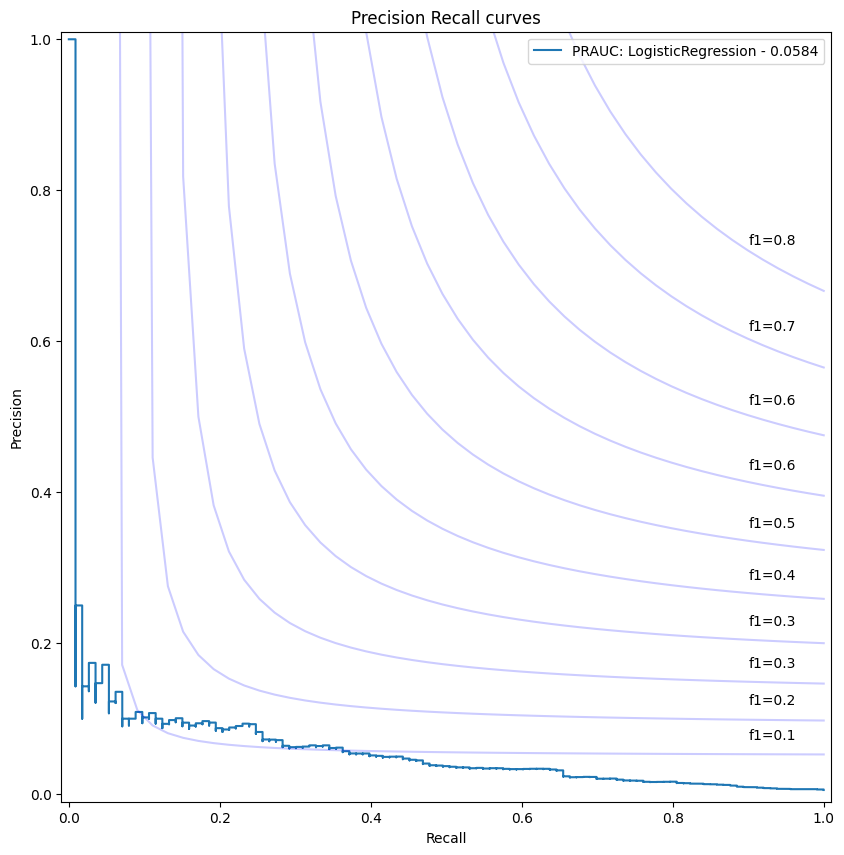

In [41]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay


def plot_precision_recall(df: pd.DataFrame, model_probas: Dict[str, np.array], figsize: Tuple[int, int] = (10, 10)) -> None:
    """Plot Precision Recall curve for the model"""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    for model_name, y_proba in model_probas.items():
        precision, recall, _ = precision_recall_curve(y_true=df["is_pumped"], probas_pred=y_proba)
        PrecisionRecallDisplay(precision=precision, recall=recall).plot(
            ax=ax, label=f"PRAUC: {model_name} - {auc(recall, precision):.4f}"
        )

    f_scores = np.linspace(0.1, 0.8, num=10)

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
        ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    plt.legend(loc="upper right")
    plt.title("Precision Recall curves")


plot_precision_recall(df=df_test, model_probas={"LogisticRegression": probas_pred_lr})

<h4>Evaluation metrics</h4>


<h4>TOP-K accuracy or Hit Ratio K</h4>

In [42]:
def calculate_topk(df_test: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]) -> Dict[int, float]:
    """Compute top-k accuracy of the model using validation sample"""

    topk_vals = []
    df_test["probas_pred"] = probas_pred

    for K in topk_bins:

        topk: List[bool] = []

        for _, df_test_pump in df_test.groupby("pump_hash"):
            df_test_pump: pd.DataFrame = df_test_pump.sort_values(
                by="probas_pred", ascending=False
            )  # sort tickers by logits
            topk_contains_pump: bool = df_test_pump.iloc[:K][
                "is_pumped"
            ].any()  # see if any of the top k logits has label is_pumped == 1
            topk.append(topk_contains_pump)

        topk_vals.append(sum(topk) / len(topk))  # probability of having true label in top-k logits

    return dict(zip(topk_bins, topk_vals))

In [43]:
topk_bins: List[int] = [1, 3, 5, 10, 20, 30]

topk: Dict[int, float] = calculate_topk(df_test=df_test, probas_pred=probas_pred_lr, topk_bins=topk_bins)

df_topk = pd.DataFrame({"K": topk.keys(), "HR@K": topk.values()})

df_topk

,K,HR@K
0,1,0.079646
1,3,0.194690
2,5,0.309735
3,10,0.469027
4,20,0.628319
5,30,0.672566


<h4>We would like to have a metric taking into account top-k performance for all Ks</h4>


$$\text{Avg} \hspace{0.25em} \frac{\partial{\text{TOP-K}}}{\partial{K}} \approx \frac{1}{|K|} \sum_{k \in K} \frac{\Delta \text{TOP-k}}{\Delta k} \hspace{1em} \text{where} \hspace{0.25em} K = \{1, 3, 5, 10, 20, 30\}$$

In [44]:
# We would like to maximize returns on increasing K
def calculate_mean_topk_derivative(df: pd.DataFrame, probas_pred: np.array, topk_bins: List[int]) -> float:
    """Calculates average mean increase in TOP-K as K increases"""
    topk: Dict[int, float] = calculate_topk(df=df, probas_pred=probas_pred, topk_bins=topk_bins)

    df_topk = pd.DataFrame({"K": topk.keys(), "HR@K": topk.values()})

    return np.mean(df_topk["HR@K"].diff() / df_topk["K"].diff())

<h4>TOP-K%</h4>

All cross-sections are of different sizes therefore it will be better to use TOP-K% instead of just K. This metric shows the probability of having a true label withing K% of the alternatives

In [45]:
def calculate_topk_percent(df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array) -> Dict[float, float]:
    """Calculates TOP-K% for a given model and ground truth stored in df"""

    dfc: pd.DataFrame = df.copy()
    dfc["probas_pred"] = probas_pred

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_hash"):
        df_pump: pd.DataFrame = df_pump.sort_values(by="probas_pred", ascending=False)  # sort tickers by logits
        # calculate percentages
        df_pump = df_pump.reset_index(drop=True)  # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio[
                "is_pumped"
            ].any()  # see if any of the top k% logits has label is_pumped == 1
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}


calculate_topk_percent(df=df_test, probas_pred=probas_pred_lr, topk_share_bins=[0.1, 0.2, 0.3, 0.4, 0.5])

{0.1: 0.6017699115044248,
 0.2: 0.7345132743362832,
 0.3: 0.8141592920353983,
 0.4: 0.8495575221238938,
 0.5: 0.8938053097345132}

<h4>TOP-K% AUC</h4>

In [46]:
def calculate_topk_percent_auc(df: pd.DataFrame, probas_pred: np.array, topk_share_bins: np.array) -> float:
    """Calculates Area under TOP-K% curve"""
    topk: Dict[float, float] = calculate_topk_percent(df=df, probas_pred=probas_pred, topk_share_bins=topk_share_bins)
    topk_vals: List[float] = list(topk.values())
    return auc(x=topk_share_bins, y=topk_vals)


X = np.arange(0.01, 1.01, 0.01)

calculate_topk_percent_auc(df=df_test, probas_pred=probas_pred_lr, topk_share_bins=X)

0.8302654867256637

<h4>Logistic Regression Tuned</h4>

<p>We added regulirization to Logistic Regression to see if it can further improve it</p>

In [47]:
class KFoldCrosssection:

    def __init__(self, n_splits: int) -> Self:
        self.n_splits: int = n_splits

    def split(self, df: pd.DataFrame) -> Iterable[Union[pd.DataFrame, pd.DataFrame]]:
        """Split dataframe into K contiguous splits taking into account cross-sectional structure of the data"""
        bins: np.array = np.linspace(df["pump_id"].min(), df["pump_id"].max(), self.n_splits)

        for i in range(1, len(bins)):
            val_fold: pd.Series = (df["pump_id"] >= bins[i - 1]) & (df["pump_id"] < bins[i])  # splits based on pump_ids
            train, val = df[~val_fold].copy(), df[val_fold].copy()

            yield train, val

<h4>Find the best set of hyperparameters using Optuna</h4>

In [48]:
from optuna.trial import Trial
from functools import partial

import optuna


def objective_lr(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str, fold: KFoldCrosssection
) -> Tuple[float, float]:
    """Optimize LogisticRegression hyperparameters to maximize TOP-K% AUC evaluation metric"""

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01)  # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    lr_params = dict(
        class_weight="balanced",
        penalty="l1",
        solver="liblinear",
        max_iter=10000,
        n_jobs=-1,
        C=1 / trial.suggest_float("lambda", 0.1, 1000),  # C = 1/lambda
    )

    for train, val in fold.split(df_train):

        model = LogisticRegression(**lr_params)
        model = model.fit(X=train[reg_cols], y=train[target])
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1]  # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc)  # optimize for top-30 accuracy

    return np.mean(topk_percent_auc_scores)  # return average top-k auc

In [49]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_lr = optuna.create_study(direction="maximize")

study_lr.optimize(
    partial(objective_lr, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), n_trials=5
)

[I 2024-08-17 14:33:45,855] A new study created in memory with name: no-name-5369d835-3435-4a72-95e8-c3eae07802b4
[I 2024-08-17 14:33:56,518] Trial 0 finished with value: 0.7485418451703011 and parameters: {'lambda': 59.7957828732057}. Best is trial 0 with value: 0.7485418451703011.
[I 2024-08-17 14:34:07,115] Trial 1 finished with value: 0.7369855187838068 and parameters: {'lambda': 479.7135257318054}. Best is trial 0 with value: 0.7485418451703011.
[I 2024-08-17 14:34:21,340] Trial 2 finished with value: 0.735644597304508 and parameters: {'lambda': 532.8986920909172}. Best is trial 0 with value: 0.7485418451703011.
[I 2024-08-17 14:34:28,750] Trial 3 finished with value: 0.7399214769042419 and parameters: {'lambda': 293.9828243180184}. Best is trial 0 with value: 0.7485418451703011.
[I 2024-08-17 14:34:35,922] Trial 4 finished with value: 0.7284448643633603 and parameters: {'lambda': 798.4559461100022}. Best is trial 0 with value: 0.7485418451703011.


In [50]:
l1_lambda = study_lr.best_params["lambda"]

model_lr_tuned = LogisticRegression(
    class_weight="balanced", penalty="l1", solver="liblinear", max_iter=10000, n_jobs=-1, C=1 / l1_lambda
)

model_lr_tuned.fit(df_train[reg_cols], df_train["is_pumped"])

LogisticRegression(C=0.016723587382749976, class_weight='balanced',
                   max_iter=10000, n_jobs=-1, penalty='l1', solver='liblinear')

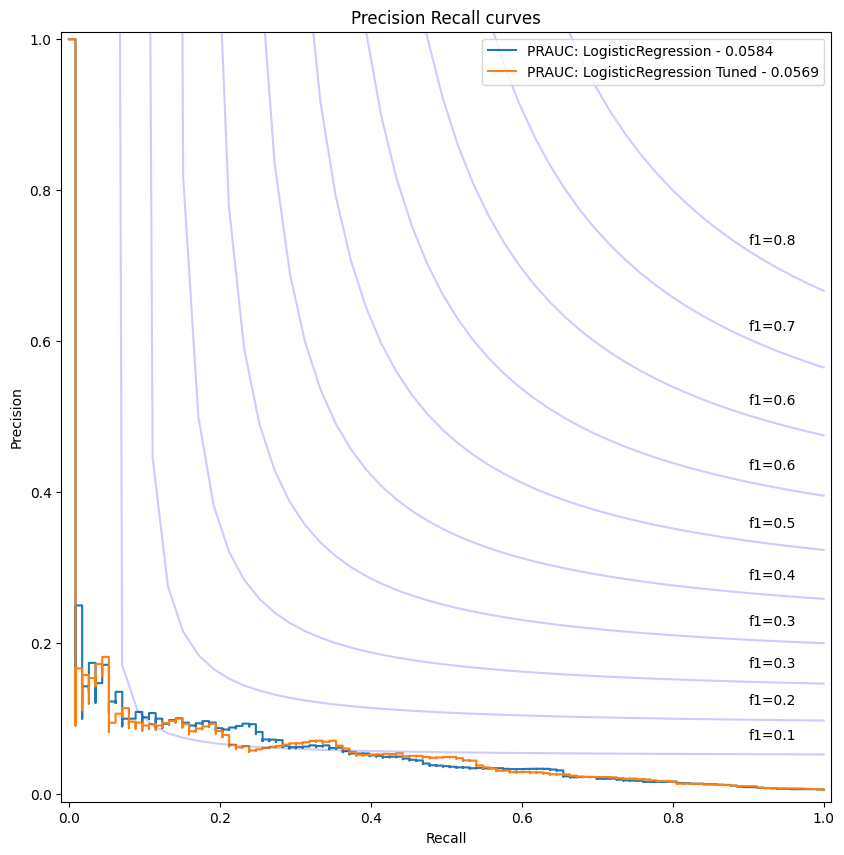

In [51]:
probas_pred_lr_tuned = model_lr_tuned.predict_proba(df_test[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={"LogisticRegression": probas_pred_lr, "LogisticRegression Tuned": probas_pred_lr_tuned}
)

plt.show()

In [52]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_lr_tuned, topk_bins=topk_bins)

{1: 0.08849557522123894,
 3: 0.20353982300884957,
 5: 0.2920353982300885,
 10: 0.45132743362831856,
 20: 0.6106194690265486,
 30: 0.7079646017699115}

<h4>RandomForest Classifier</h4>

In [93]:
from sklearn.ensemble import RandomForestClassifier
from optuna.trial import Trial
from functools import partial


def objective_rf(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str, fold: KFoldCrosssection
) -> Tuple[float, float]:
    """Optimize RandomForest hyperparameters to maximize TOP-K% AUC evaluation metric"""

    model = RandomForestClassifier(
        criterion="gini",
        class_weight="balanced",
        max_features=trial.suggest_float("max_features", 0.5, 1),
        max_samples=trial.suggest_float("max_samples", 0.5, 1),
        n_jobs=-1,  # use all 24 cpu cores
        max_depth=trial.suggest_int("max_depth", 2, 10),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
    )

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01)  # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):
        model.fit(X=train[reg_cols], y=train[target])
        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(val[reg_cols])[:, 1]  # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc)  # optimize for top-30 accuracy

    return np.mean(topk_percent_auc_scores)  # return average top-k auc

In [106]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_rf = optuna.create_study(direction="maximize")

study_rf.optimize(
    partial(objective_rf, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), n_trials=5
)

[I 2024-08-17 15:19:39,999] Trial 4 finished with value: 0.747942385339714 and parameters: {'max_features': 0.5174835707578271, 'max_samples': 0.9707844194824975, 'max_depth': 2, 'n_estimators': 1413}. Best is trial 0 with value: 0.748288778173098.
[I 2024-08-17 15:22:39,576] Trial 5 finished with value: 0.7422598745162987 and parameters: {'max_features': 0.8831970578603967, 'max_samples': 0.9215786866095954, 'max_depth': 5, 'n_estimators': 1388}. Best is trial 0 with value: 0.748288778173098.
[I 2024-08-17 15:22:55,684] Trial 6 finished with value: 0.7377263883229018 and parameters: {'max_features': 0.5205579184732744, 'max_samples': 0.7194357377083165, 'max_depth': 6, 'n_estimators': 165}. Best is trial 0 with value: 0.748288778173098.
[I 2024-08-17 15:23:34,792] Trial 7 finished with value: 0.7385862816909257 and parameters: {'max_features': 0.5784637391572114, 'max_samples': 0.6933431636686773, 'max_depth': 6, 'n_estimators': 603}. Best is trial 0 with value: 0.748288778173098.
[I 

In [107]:
model_rf = RandomForestClassifier(
    criterion="gini", 
    class_weight="balanced", 
    n_jobs=-1, **study_rf.best_params  # use all 24 cpu cores
)

model_rf.fit(df_train[reg_cols], df_train["is_pumped"])

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features=0.6391054710947173,
                       max_samples=0.5114747855961008, n_estimators=1875,
                       n_jobs=-1)

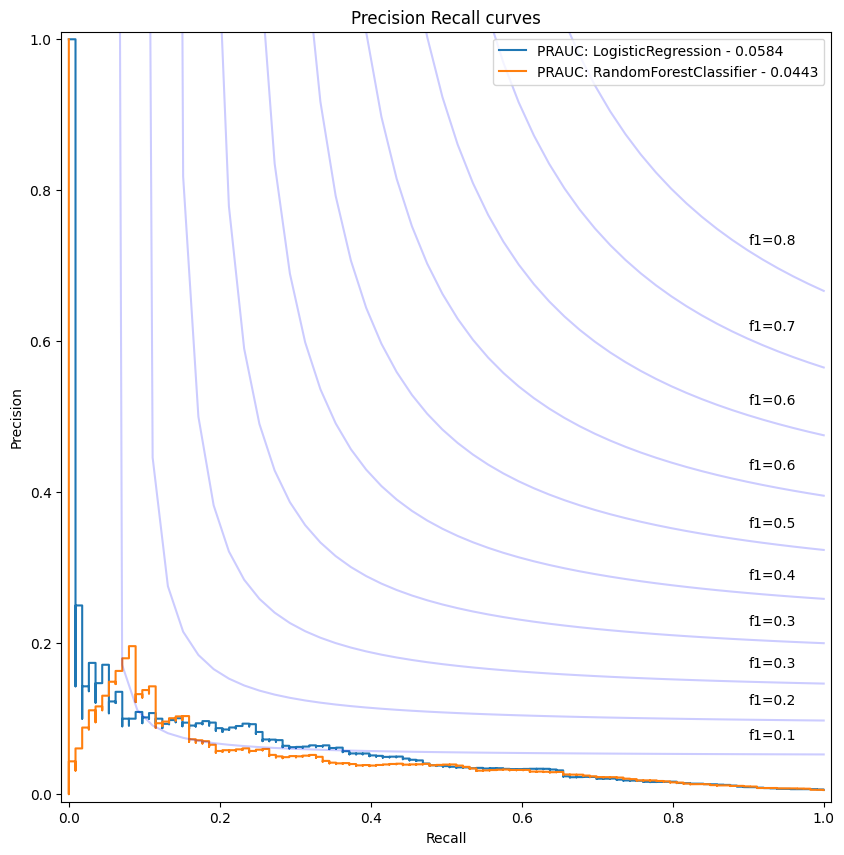

In [108]:
probas_pred_rf = model_rf.predict_proba(df_test[reg_cols])[:, 1]

ax = plot_precision_recall(
    df=df_test, model_probas={"LogisticRegression": probas_pred_lr, "RandomForestClassifier": probas_pred_rf}
)

plt.show()

In [109]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_rf, topk_bins=topk_bins)

{1: 0.10619469026548672,
 3: 0.17699115044247787,
 5: 0.24778761061946902,
 10: 0.3893805309734513,
 20: 0.5929203539823009,
 30: 0.7256637168141593,
 50: 0.8053097345132744}

<h4>CatboostClassifier</h4>

In [110]:
from catboost import CatBoostClassifier, Pool
import catboost as cb


def objective_catboost(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], target: str, fold: KFoldCrosssection
) -> float:

    cb_params = {
        "objective": "Logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "auto_class_weights": "Balanced",
    }

    num_boost_round: int = trial.suggest_int("num_boost_round", 10, 500)

    topk_percent_auc_scores: List[int] = []
    X: np.array = np.arange(0, 1.01, 0.01)  # Percentage bins for TOP-K% AUC

    train: pd.DataFrame
    val: pd.DataFrame

    for train, val in fold.split(df_train):

        ptrain: Pool = Pool(data=train[reg_cols], label=train[target], cat_features=["num_prev_pumps"])
        pval: Pool = Pool(data=val[reg_cols], label=val[target], cat_features=["num_prev_pumps"])

        # Fit the model with early stopping
        model = CatBoostClassifier(
            **cb_params, task_type="GPU", devices="0", num_boost_round=num_boost_round, border_count=255, verbose=False
        )
        model.fit(ptrain)

        # Predict probas for validation fold
        probas_pred: np.array = model.predict_proba(pval)[:, 1]  # for minority class

        topk_percent_auc: float = calculate_topk_percent_auc(df=val, probas_pred=probas_pred, topk_share_bins=X)
        topk_percent_auc_scores.append(topk_percent_auc)  # optimize for TOP-K% AUC

    return np.mean(topk_percent_auc_scores)

In [88]:
study_catboost = optuna.create_study(direction="maximize")

study_catboost.optimize(
    partial(objective_catboost, df_train=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=5
)

[I 2024-08-17 15:03:22,417] Trial 15 finished with value: 0.7532322153781317 and parameters: {'learning_rate': 0.022926332936956548, 'max_depth': 2, 'num_boost_round': 161}. Best is trial 12 with value: 0.7546031559442581.
[I 2024-08-17 15:03:48,912] Trial 16 finished with value: 0.7472752421554183 and parameters: {'learning_rate': 0.024810936892897997, 'max_depth': 2, 'num_boost_round': 200}. Best is trial 12 with value: 0.7546031559442581.
[I 2024-08-17 15:04:04,762] Trial 17 finished with value: 0.7003336526806891 and parameters: {'learning_rate': 0.07623875769633819, 'max_depth': 4, 'num_boost_round': 220}. Best is trial 12 with value: 0.7546031559442581.
[I 2024-08-17 15:04:22,807] Trial 18 finished with value: 0.7354213447680149 and parameters: {'learning_rate': 0.01874580075870346, 'max_depth': 5, 'num_boost_round': 147}. Best is trial 12 with value: 0.7546031559442581.
[I 2024-08-17 15:04:40,693] Trial 19 finished with value: 0.7469015578578171 and parameters: {'learning_rate':

In [99]:
cb_params = {
    "objective": "Logloss",
}

num_boost_round = study_catboost.best_params["num_boost_round"]

cb_params.update(study_catboost.best_params)
del cb_params["num_boost_round"]

In [100]:
ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
ptest: Pool = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])


model_cb = CatBoostClassifier(
    **cb_params,
    task_type="GPU",
    devices="0",
    num_boost_round=num_boost_round,
    verbose=False,
    border_count=255,
)
model_cb.fit(ptrain)

probas_pred_catboost = model_cb.predict_proba(ptest)[:, 1]

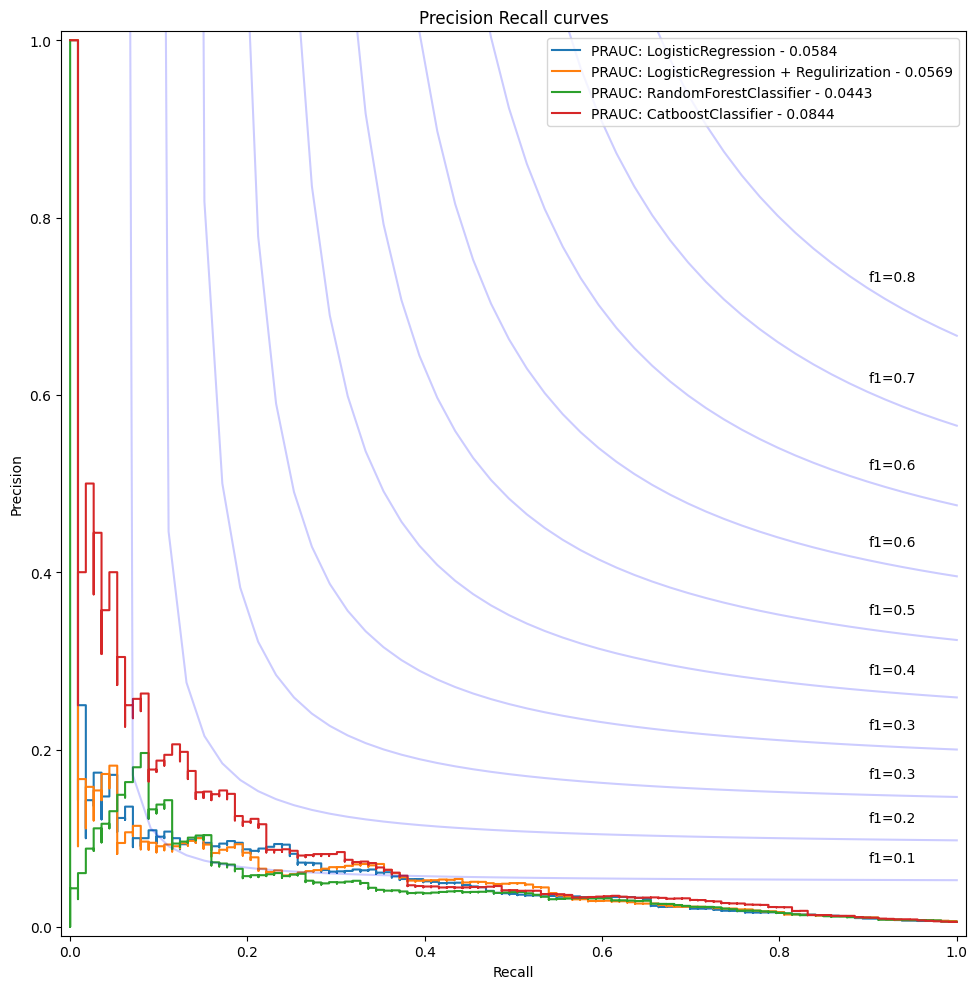

In [112]:
ax = plot_precision_recall(
    df=df_test,
    model_probas={
        "LogisticRegression": probas_pred_lr,
        "LogisticRegression + Regulirization": probas_pred_lr_tuned,
        "RandomForestClassifier": probas_pred_rf,
        # "LGBMClassifier": probas_pred_lgbm,
        "CatboostClassifier": probas_pred_catboost,
    },
)

plt.tight_layout()
# plt.savefig("precision_recall_test.png", transparent=True)
plt.show()

In [102]:
calculate_topk(df_test=df_test, probas_pred=probas_pred_catboost, topk_bins=topk_bins)

{1: 0.168141592920354,
 3: 0.24778761061946902,
 5: 0.34513274336283184,
 10: 0.4424778761061947,
 20: 0.672566371681416,
 30: 0.7610619469026548,
 50: 0.8230088495575221}

<h4>Ranking</h4>

In [103]:
# TOPK AUC
from sklearn.metrics import auc


def calculate_topk_percent_ranking(df: pd.DataFrame, relevance_scores: np.array, topk_share_bins: np.array):

    dfc: pd.DataFrame = df.copy()
    # Rank assets by relevance score
    dfc["relevance_score"] = relevance_scores
    dfc["predicted_rank"] = dfc.groupby("pump_id")["relevance_score"].rank(ascending=False)

    topk_vals: Dict[float, List[float]] = {K: [] for K in topk_share_bins}

    for _, df_pump in dfc.groupby("pump_id"):
        df_pump: pd.DataFrame = df_pump.sort_values(
            by="predicted_rank", ascending=False
        )  # sort tickers by their predicted rank

        # calculate percentages
        df_pump = df_pump.reset_index(drop=True)  # reset index based off which we will compute percentage
        df_pump["percentage"] = (df_pump.index + 1) / df_pump.shape[0]

        for K in topk_share_bins:
            # leave observations below K% of the cross-section
            df_pump_portfolio: pd.DataFrame = df_pump[df_pump["percentage"] <= K].copy()
            topk_contains_pump: bool = df_pump_portfolio["is_pumped"].any()  # see if any of the top k% rankings are pumps
            topk_vals[K].append(topk_contains_pump)

    return {K: np.mean(topk_vals[K]) for K in topk_share_bins}


def calculate_topk_percent_auc_ranking(df: pd.DataFrame, relevance_scores: np.array, topk_share_bins: np.array) -> float:
    """Calculates Area under TOP-K% curve"""
    topk: Dict[float, float] = calculate_topk_percent_ranking(
        df=df, relevance_scores=relevance_scores, topk_share_bins=topk_share_bins
    )
    topk_vals: List[float] = list(topk.values())
    return auc(x=topk_share_bins, y=topk_vals)

In [104]:
from optuna.trial import Trial
from functools import partial
from catboost import CatBoostRanker, Pool

import optuna


def objective_cb_ranking(
    trial: Trial, df_train: pd.DataFrame, reg_cols: List[str], fold: KFoldCrosssection
) -> Tuple[float, float]:

    train: pd.DataFrame
    val: pd.DataFrame

    cb_params = dict(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2),
        max_depth=trial.suggest_int("max_depth", 2, 5),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.7, 1),
        # Non-tunable params
        objective="YetiRank:mode=NDCG",
        border_count=255,
        verbose=False,
    )

    topk_auc_scores: List[float] = []

    X: np.array = np.arange(0, 1.01, 0.01)  # Percentage bins for TOP-K% AUC

    for train, val in fold.split(df_train):
        model = CatBoostRanker(**cb_params)

        ptrain: Pool = Pool(
            data=train[reg_cols],
            cat_features=["num_prev_pumps"],
            label=train["asset_return_inv_pct_rank"],
            group_id=train["pump_id"],
        )
        pval: Pool = Pool(
            data=val[reg_cols],
            cat_features=["num_prev_pumps"],
            label=val["asset_return_inv_pct_rank"],
            group_id=val["pump_id"],
        )

        model = model.fit(ptrain)
        # Predict rankings on validation sample
        relevance_scores: np.array = model.predict(pval)

        topk_auc_scores.append(
            calculate_topk_percent_auc_ranking(df=val, relevance_scores=relevance_scores, topk_share_bins=X)
        )

    return np.mean(topk_auc_scores)

In [80]:
df_train["asset_return_inv_pct_rank"] = df_train.groupby("pump_id")["asset_return"].rank(pct=True, ascending=True)

In [ ]:
fold = KFoldCrosssection(n_splits=5)

# run optuna study to maximize top_k over hyperparams
study_ranking = optuna.create_study(direction="maximize")

study_ranking.optimize(
    partial(objective_cb_ranking, df_train=df_train, reg_cols=reg_cols, fold=fold), n_trials=25
)

In [82]:
ptrain: Pool = Pool(
    data=df_train[reg_cols],
    cat_features=["num_prev_pumps"],
    label=df_train["asset_return_inv_pct_rank"],
    group_id=df_train["pump_id"],
)

ptest: Pool = Pool(data=df_test[reg_cols], cat_features=["num_prev_pumps"], group_id=df_test["pump_id"])

model_cb_params = dict(
    objective="YetiRank:mode=NDCG", border_count=255, verbose=False
)

model_cb_params.update(study_ranking.best_params)

In [83]:
cb_ranker = CatBoostRanker(**model_cb_params)
cb_ranker = cb_ranker.fit(ptrain)

In [84]:
def compute_topk_ranking(df: pd.DataFrame, relevance_scores: np.array, topk_bins: List[int]) -> Dict[float, float]:

    df["relevance_score"] = relevance_scores
    df["predicted_rank"] = df.groupby("pump_id")["relevance_score"].rank(ascending=True)

    num_pumps_train: int = df["is_pumped"].sum()

    topk_scores: List[float] = []

    for K in topk_bins:
        num_caught_pumps: int = df[df["is_pumped"] & (df["predicted_rank"] <= K)].shape[0]

        topk_scores.append(
            # topk-recall
            num_caught_pumps
            / num_pumps_train
        )

    return dict(zip(topk_bins, topk_scores))

In [85]:
relevance_scores: np.array = cb_ranker.predict(ptest)

compute_topk_ranking(
    df=df_test, relevance_scores=relevance_scores, topk_bins=topk_bins
)

{1: 0.0,
 3: 0.0,
 5: 0.008849557522123894,
 10: 0.02654867256637168,
 20: 0.04424778761061947,
 30: 0.05309734513274336,
 50: 0.11504424778761062}

In [111]:
model_probas = {
    "LogisticRegression": probas_pred_lr,
    "LogisticRegression Tuned": probas_pred_lr_tuned,
    "RandomForest Tuned": probas_pred_rf,
    # "LGBMClassifier Tuned": probas_pred_lgbm,
    "CatboostClassifier": probas_pred_catboost,
}

topk_bins = [1, 3, 5, 10, 20, 30, 50]

res = []

for name, proba in model_probas.items():
    topk_vals = calculate_topk(df_test=df_test, probas_pred=proba, topk_bins=topk_bins).values()
    res.append(list(topk_vals))

df_topk = pd.DataFrame(data=res).T

df_topk.columns = model_probas.keys()
df_topk.index = [f"TOP-{i}" for i in topk_bins]

df_topk

,LogisticRegression,LogisticRegression Tuned,RandomForest Tuned,CatboostClassifier
TOP-1,0.079646,0.088496,0.106195,0.168142
TOP-3,0.194690,0.203540,0.176991,0.247788
TOP-5,0.309735,0.292035,0.247788,0.345133
TOP-10,0.469027,0.451327,0.389381,0.442478
TOP-20,0.628319,0.610619,0.592920,0.672566
TOP-30,0.672566,0.707965,0.725664,0.761062
TOP-50,0.805310,0.823009,0.805310,0.823009
